In [ ]:
import sys
import time
import numpy as np
import math
import pandas as pd
from sklearn.utils.validation import check_X_y
from honest_forests.estimators import HonestForestClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.validation import check_X_y
from sklearn.utils.multiclass import check_classification_targets
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import scipy.stats as stats
from joblib import Parallel, delayed

In [16]:
##Simulation Data 
#https://nbviewer.org/github/rflperry/math_tutorials/blob/master/tutorials/StatPatternRecognition/Trunk.ipynb

def simulate(n, d):
    n1 = np.random.binomial(n, 0.5)
    n2 = n - n1
    mu = 1 / np.sqrt(np.arange(1, d+1))

    X = np.vstack((
        np.random.normal(mu, 1, (n1, d)),
        np.random.normal(-mu, 1,  (n2, d))
    ))
    
    return X, np.asarray([1]*n1 + [0]*n2)


In [ ]:
def Posterior_After(X,v,X_sample,tree_i):
    
    #Duplicate the sigle sample test
    X_testsample_duplicated = np.tile(X,(X_sample.shape[0],1))
    
    ### Replace test data with values from structure subset   
    X_variable = X_sample[:,v]
    
    X_testsample_duplicated[:,v] = X_variable
    X_testsample_duplicated = X_testsample_duplicated.astype(np.float32)
    
    #Obtain the possible leaves with ignoring variable v
    leaves_indicies = np.unique(tree_i.tree_.apply(X_testsample_duplicated)) 
    value_leaves = np.sum(tree_i.tree_.value[leaves_indicies], axis=0)
    
    #Calculate the posterior probability for sample x
    
    posterior_proba = value_leaves/np.sum(value_leaves) 
    
    
    return value_leaves,posterior_proba
    
    

In [18]:
def SCORE(tree_i,X,y):
    X_structure = X[tree_i.structure_indices_]
    X_honest = X[tree_i.honest_indices_]
    y_honest  = y[tree_i.honest_indices_]
        
    leaves_indicies_before = tree_i.tree_.apply(X_honest.astype(np.float32))
    value_leaves_before = tree_i.tree_.value[leaves_indicies_before]
    classification_before = np.zeros(X_honest.shape[0])
    #error_before = np.zeros((X_honest.shape[0],1))
        
    posterior_proba_before = np.zeros((X_honest.shape[0],2))##n_classes
    value_leaves = np.zeros((X_honest.shape[0],2))
    posterior_proba = np.zeros((X_honest.shape[0],2))
    classification_after = np.zeros(X_honest.shape[0])
    difference_clf = np.zeros(X_honest.shape[0])
    #error_after = np.zeros((X_honest.shape[0],1))
        
    mean_diff = []
    for k in range(0,X_honest.shape[1]):
        for i in range(0,X_honest.shape[0]):
            ##Compute posterior probability before merging
            posterior_proba_before[i,:] = value_leaves_before[i,:]/np.sum(value_leaves_before[i,:])
            ##Compute posterior probability after merging
            value_leaves[i,:],posterior_proba[i,:] = Posterior_After(X_honest[i,:],k,X_structure,tree_i)
            #Compute the difference of posterior possibility for just one class
            
        ## Get the classification_before result
        classification_before = posterior_proba_before.argmax(1)
        #print(classification_before)
        ## Get the classification_after result
        classification_after = posterior_proba.argmax(1)
            
        #Calculate classification error before 
        error_before = np.mean(np.abs(y_honest - classification_before))
        #Calculate classification error after merging leaves
        error_after = np.mean(np.abs(y_honest - classification_after))
        #Calculate the difference of classification error
        difference_clf = error_after - error_before
        mean_diff = np.append(mean_diff,difference_clf)
    return mean_diff

In [19]:
###Compute te honest truth
d = 20
N = 100
n = 500
n_estimator = 100
n_repeat = 20
ER_Ture = np.zeros((N,d))
for num in range(0,N):
    print(num)
    X_train, y_train = simulate(n = n, d = d)
    
    clf_trueHF = HonestForestClassifier(honest_fraction = 0.8, n_estimators=n_estimator,max_features = d,bootstrap = False)
    clf_trueHF = clf_trueHF.fit(X_train,y_train)
    
#    X_test, y_test = simulate(n = n, d = d)
    X_test = np.zeros((n,d))
    y_test = y_train
    for k in range(0,n):
        X_test[k,:] = X_train[k,:]
    error_whole = []
    error_honest = []
    
    y_predict_origin = clf_trueHF.predict(X_test)
    ###Compute original error with the whole set
    er_origin = np.mean(np.abs(y_predict_origin - y_test))
#    print("ER_origin " + str(er_origin))
    
#     ###Compute original error with the honest set
#     X_structure_org = X[clf_trueHT.structure_indices_]
#     X_honest_org = X[clf_trueHT.honest_indices_]
#     y_honest_org  = y_train[clf_trueHT.honest_indices_]
#     leaves_indicies_before_org = clf_trueHT.tree_.apply(X_honest_org.astype(np.float32))
#     value_leaves_before_org = clf_trueHT.tree_.value[leaves_indicies_before_org]
#     classification_before_org = np.zeros(X_honest_org.shape[0])
#     posterior_proba_before_org = np.zeros((X_honest_org.shape[0],2))##n_classes
#     for i in range(0,X_honest_org.shape[0]):
#         posterior_proba_before_org[i,:] = value_leaves_before_org[i,:]/np.sum(value_leaves_before_org[i,:])
#         classification_before_org = posterior_proba_before_org.argmax(1)
#         error_originHT = np.mean(np.abs(y_honest_org - classification_before_org))
    
    
    
    ###Compute corrupted error with the whole set 
    y_repeat = np.repeat(y_test,n_repeat)
    X_repeat = np.repeat(X_test,n_repeat,axis = 0)
    
    error_clf = []
    n1 = len(np.argwhere(y_test == 1))
    n2 = len(np.argwhere(y_test == 0))
    mu = 1 / np.sqrt(np.arange(1, d+1))
    
    for d_i in range(0,X_test.shape[1]):
        X = np.zeros((X_test.shape[0]*n_repeat,X_test.shape[1]))
        for j in range(0,X_test.shape[1]):
            X[:,j] = X_repeat[:,j]
#        print(np.sum(X-X_repeat))
        ##resample for target feature
        mu_i = mu[d_i]
        X_di = []
        for k in range(0,n1+n2):
            if y_test[k] == 0:
                X_di = np.append(X_di,np.random.normal(-mu_i, 1, n_repeat))
            if y_test[k] == 1:
                X_di = np.append(X_di,np.random.normal(mu_i, 1, n_repeat))
        X[:,d_i] = X_di
#        print(np.sum(X-X_repeat))
#        print(X[:,d_i])
        y_predict = clf_trueHF.predict(X)
        error_condition = np.mean(np.abs(y_predict - y_repeat))
#        print("ER_condition " + str(error_condition))
        error_clf = np.append(error_clf, error_condition - er_origin)
    ER_Ture[num,:] =  error_clf  
    
    

0
4
5
8
9
11
12
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [20]:
score_hf = np.zeros((N,d))## HFIM
#Calculter Permutation Based HF socre
score_hfp = np.zeros((N,d))## Permutation FIM with honest forest

#Calculter Permutation Based RF socre
score_rfp_WB = np.zeros((N,d))
score_rfp_WOB = np.zeros((N,d))


for num in range(0,N):
    print(num)
    X_train, y_train = simulate(n=n, d=d)

    #Train an Honest Tree
    ###We find that the honest tree nust be full trained？
    ###there will be difference for the rank of feature imporatnces  
    #t_ht = time.time()
    clf = HonestForestClassifier(honest_fraction = 0.8, n_estimators = n_estimator,max_features = d,bootstrap = False)
    clf = clf.fit(X_train, y_train)
    score_tree = Parallel(n_jobs=-1)(delayed(SCORE)(tree_i,X_train,y_train) for tree_i in (clf.estimators_))

    #Save HF socre
    score_hf[num,:] = np.mean(score_tree,axis = 0)
    
    r_hf = permutation_importance(clf, X_train, y_train,n_repeats=5,random_state=0)
    score_hfp[num,:] = r_hf.importances_mean
    
    clf_rf_WB = RandomForestClassifier(n_estimators = n_estimator,max_features = d)
    clf_rf_WB = clf_rf_WB.fit(X_train, y_train)
    
    r_rf_WB = permutation_importance(clf_rf_WB, X_train, y_train,n_repeats=5,random_state=0)
    score_rfp_WB[num,:] = r_rf_WB.importances_mean

    clf_rf_WOB = RandomForestClassifier(n_estimators = n_estimator,max_features = d,bootstrap = False)
    clf_rf_WOB = clf_rf_WOB.fit(X_train, y_train)
    
    r_rf_WOB = permutation_importance(clf_rf_WOB, X_train, y_train,n_repeats=5,random_state=0)
    score_rfp_WOB[num,:] = r_rf_WOB.importances_mean
    

0
3
5
6
7
8
9
10
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


average width of 95% CI of HF True FI Score is 0.0010832386695497755
average width of 95% CI of HFIM Score is 0.0010684146925565186
average width of 95% CI of Permutation FIM Score HF is 0.0017662050251619904
average width of 95% CI of Permutation FIM Score RF is 0.003219484002126621


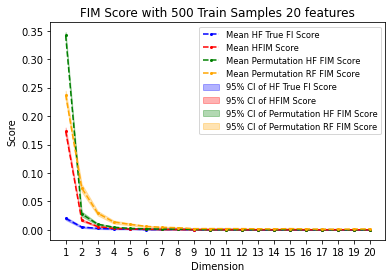

In [21]:
#### Calculate 95% CI of HT socre around 100 times iterations
score_Ture_mean = np.mean(ER_Ture,axis = 0)
ci_Ture_low,ci_Ture_up = stats.t.interval(0.95, N-1, loc=np.mean(ER_Ture,axis = 0), scale=stats.sem(ER_Ture,axis = 0))
plt.plot(np.arange(1,d+1,1),score_Ture_mean,
         'b--',marker='o', markersize=2,label = 'Mean HF True FI Score')
plt.fill_between(np.arange(1,d+1,1),ci_Ture_low,ci_Ture_up,
                 alpha = 0.3,color = 'blue',label = '95% CI of HF True FI Score')

width_Ture = np.mean(ci_Ture_up-ci_Ture_low)
print("average width of 95% CI of HF True FI Score is " + str(width_Ture))


#Calculate 95% CI of HT socre around 100 times iterations
score_hf_mean = np.mean(score_hf,axis = 0)
ci_hf_low,ci_hf_up = stats.t.interval(0.95, N-1, loc=np.mean(score_hf,axis = 0), scale=stats.sem(score_hf,axis = 0))
plt.plot(np.arange(1,d+1,1),score_hf_mean,
         'r--',marker='o', markersize=2,label = 'Mean HFIM Score')
plt.fill_between(np.arange(1,d+1,1),ci_hf_low,ci_hf_up,
                 alpha = 0.3,color = 'red',label = '95% CI of HFIM Score')

width_hf = np.mean(ci_hf_up-ci_hf_low)
print("average width of 95% CI of HFIM Score is " + str(width_hf))

#Calculate 95% CI of Permutation Based HF socre around 50 times iterations
score_hfp_mean = np.mean(score_hfp,axis = 0)
ci_hfp_low,ci_hfp_up = stats.t.interval(0.95, N-1, loc=np.mean(score_hfp,axis = 0), scale=stats.sem(score_hfp,axis = 0))
plt.plot(np.arange(1,d+1,1),score_hfp_mean,
         'g--',marker='o', markersize=2,label = 'Mean Permutation HF FIM Score')
plt.fill_between(np.arange(1,d+1,1),ci_hfp_low,ci_hfp_up,
                 alpha = 0.3,color ='green',label = '95% CI of Permutation HF FIM Score')

width_hfp = np.mean(ci_hfp_up-ci_hfp_low)
print("average width of 95% CI of Permutation FIM Score HF is "+str(width_hfp))


#Calculate 95% CI of Permutation Based RF socre around 50 times iterations
score_rfp_WB_mean = np.mean(score_rfp_WB,axis = 0)
ci_rfp_WB_low,ci_rfp_WB_up = stats.t.interval(0.95, N-1, loc=np.mean(score_rfp_WB,axis = 0), scale=stats.sem(score_rfp_WB,axis = 0))
plt.plot(np.arange(1,d+1,1),score_rfp_WB_mean,
         linestyle = "--",color ='orange',marker='o', markersize=2,label = 'Mean Permutation RF FIM Score')
plt.fill_between(np.arange(1,d+1,1),ci_rfp_WB_low,ci_rfp_WB_up,
                 alpha = 0.3,color ='orange',label = '95% CI of Permutation RF FIM Score')

width_hfp_WB = np.mean(ci_rfp_WB_up-ci_rfp_WB_low)
print("average width of 95% CI of Permutation FIM Score RF is "+str(width_hfp_WB))

# #Calculate 95% CI of Permutation Based RF socre around 50 times iterations
# score_rfp_WOB_mean = np.mean(score_rfp_WOB,axis = 0)
# ci_rfp_WOB_low,ci_rfp_WOB_up = stats.t.interval(0.95, N-1, loc=np.mean(score_rfp_WOB,axis = 0), scale=stats.sem(score_rfp_WOB,axis = 0))
# plt.plot(np.arange(1,d+1,1),score_rfp_WOB_mean,
#          linestyle = "--",color ='cyan',marker='o', markersize=2,label = 'Mean Permutation RF without Boostrap FIM Score')
# plt.fill_between(np.arange(1,d+1,1),ci_rfp_WOB_low,ci_rfp_WOB_up,
#                  alpha = 0.3,color ='cyan',label = '95% CI of Permutation RF without Boostrap FIM Score')

# width_hfp_WOB = np.mean(ci_rfp_WOB_up-ci_rfp_WOB_low)
# print("average width of 95% CI of Permutation without Boostrap FIM Score RF is "+str(width_hfp_WOB))


#Calculate the real importance score


plt.xticks(np.arange(1, d+1, 1))
#plt.yticks(np.arange(0, 0.4, 0.05))
plt.xlabel('Dimension')
plt.ylabel('Score')
plt.legend(loc = 'upper right',fontsize = 'small')
plt.title('FIM Score with 500 Train Samples 20 features')
#plt.savefig('95% CI of FIM Score with 500 Train Samples',bbox_inches = 'tight')
plt.show()




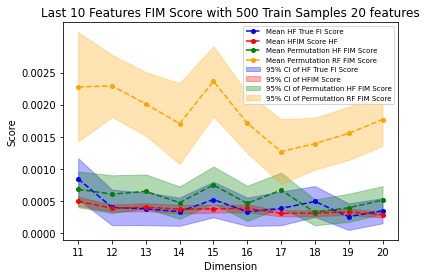

In [22]:
plt.plot(np.arange(11,d+1,1),score_Ture_mean[10:],
         "b--",marker='o', markersize=4,label = 'Mean HF True FI Score')
plt.fill_between(np.arange(11,d+1,1),ci_Ture_low[10:],ci_Ture_up[10:],
                 alpha = 0.3,color = 'blue',label = '95% CI of HF True FI Score')


plt.plot(np.arange(11,d+1,1),score_hf_mean[10:],
         'r--',marker='o', markersize=4,label = 'Mean HFIM Score HF')
plt.fill_between(np.arange(11,d+1,1),ci_hf_low[10:],ci_hf_up[10:],
                 alpha = 0.3,color = 'red',label = '95% CI of HFIM Score')

plt.plot(np.arange(11,d+1,1),score_hfp_mean[10:],
         'g--',marker='o', markersize=4,label = 'Mean Permutation HF FIM Score')
plt.fill_between(np.arange(11,d+1,1),ci_hfp_low[10:],ci_hfp_up[10:],
                 alpha = 0.3,color = 'green',label = '95% CI of Permutation HF FIM Score')

plt.plot(np.arange(11,d+1,1),score_rfp_WB_mean[10:],
         linestyle = "--",color ='orange',marker='o', markersize=4,label = 'Mean Permutation RF FIM Score')
plt.fill_between(np.arange(11,d+1,1),ci_rfp_WB_low[10:],ci_rfp_WB_up[10:],
                 alpha = 0.3,color = 'orange',label = '95% CI of Permutation RF FIM Score')

# plt.plot(np.arange(11,d+1,1),score_rfp_WOB_mean[10:],
#          linestyle = "--",color ='cyan',marker='o', markersize=4,label = 'Mean Permutation RF without Boostrap FIM Score')
# plt.fill_between(np.arange(11,d+1,1),ci_rfp_WOB_low[10:],ci_rfp_WOB_up[10:],
#                  alpha = 0.3,color = 'cyan',label = '95% CI of Permutation RF without Boostrap FIM Score')



plt.xticks(np.arange(11, d+1, 1))
plt.yticks(np.arange(0, 0.0030, 0.0005))
plt.xlabel('Dimension')
plt.ylabel('Score')
plt.legend(loc = 'upper right',fontsize = 'x-small')
plt.title('Last 10 Features FIM Score with 500 Train Samples 20 features')
#plt.savefig('95% CI of FIM Score with 500 Train Samples',bbox_inches = 'tight')
plt.show()